In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,42257,None,None,85802.383343
2020-06-13,42258,None,None,79706.450373
2020-06-14,42259,None,None,74051.611199
2020-06-15,42260,None,None,68724.950343
2020-06-16,42261,None,None,63980.011203
...,...,...,...,...
2021-03-24,42542,None,None,72565.955997
2021-03-25,42543,None,None,71829.778434
2021-03-26,42544,None,None,71135.499115


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-28_2021-03-28-16-18.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-27_2021-03-27-16-46.pickle


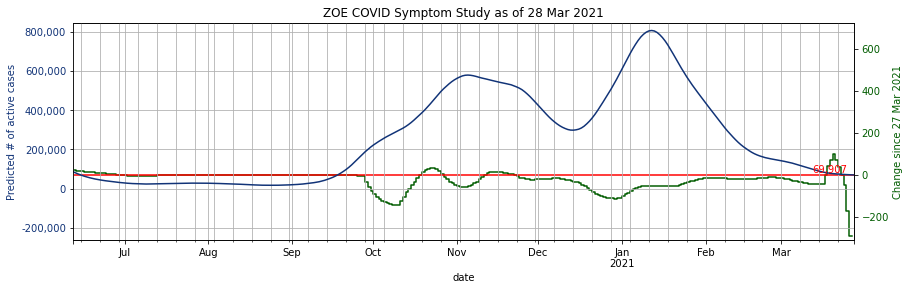

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

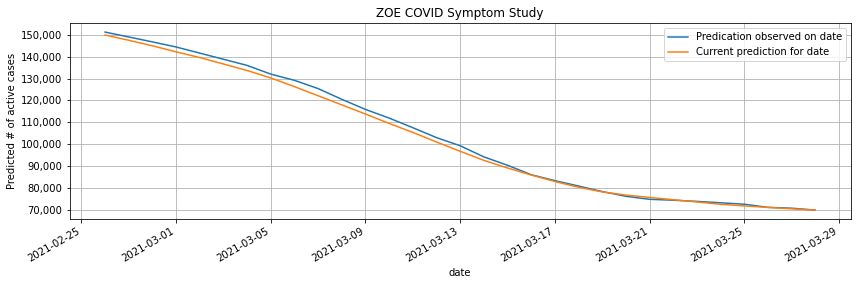

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-28_2021-03-28-16-19.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
289,Dumfries and Galloway,S12000006,0.672755
54,Luton,E06000032,0.625702
324,East Dunbartonshire,S12000045,0.589935
328,Conwy,W06000003,0.585937
367,Ards and North Down,N09000011,0.552916
206,Ashfield,E07000170,0.425220
153,North West Leicestershire,E07000134,0.414795
354,Westminster,E09000033,0.408324
372,Moray,S12000020,0.398499
17,North East Lincolnshire,E06000012,0.397514
